# **Q2. **Audio Reconstruction** - Pick a 5-second audio sample of your liking. Use Random Fourier Features (RFF) and Linear Regression to learn the mapping from time $(t)$ to amplitude $(A)$, where $t$ is the time point, and $A$ is the audio amplitude at that time. Play the reconstructed audio and the original audio to demonstrate reconstruction. Calculate the Root Mean Squared Error (RMSE) and Signal-to-Noise Ratio (SNR) to evaluate the reconstruction. **[1.5 Mark]****

**Answer 2:** Importing Latexify and required libraries:

In [6]:
!sudo apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended
from latexify import latexify
latexify(columns = 2)
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import soundfile

%matplotlib inline
%config InlineBackend.figure_format = "retina"

if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(device)

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  cm-super-minimal dvisvgm fonts-droid-fallback fonts-lato fonts-lmodern
  fonts-noto-mono fonts-texgyre fonts-urw-base35 ghostscript
  libapache-pom-java libcommons-logging-java libcommons-parent-java
  libfontbox-java libfontenc1 libgs9 libgs9-common libidn12 libijs-0.35
  libjbig2dec0 libkpathsea6 libpdfbox-java libptexenc1 libruby3.0 libsynctex2
  libteckit0 libtexlua53 libtexluajit2 libwoff1 libzzip-0-13 lmodern
  pfb2t1c2pfb poppler-data preview-latex-style rake ruby ruby-net-telnet
  ruby-rubygems ruby-webrick ruby-xmlrpc ruby3.0 rubygems-integration t1utils
  tex-common tex-gyre texlive-base texlive-binaries texlive-fonts-recommended
  texlive-latex-base texlive-pictures texlive-plain-generic tipa
  xfonts-encodings xfonts-utils
Suggested packages:
  fonts-noto fonts-freefont-otf | fonts-freefont-ttf ghostscript-x
  libavalon-fram

**Importing audio and Sampling Rate**

In [7]:
from IPython.display import Audio
Audio('audio.wav')
import torchaudio
audio, sr = torchaudio.load('./audio.wav')
print(sr)
print(audio.shape)
audio = audio[0]
tm = audio.shape[0] / sr
print(f"Audio length: {tm} seconds")
print(audio)

48000
torch.Size([2, 309888])
Audio length: 6.456 seconds
tensor([0., 0., 0.,  ..., 0., 0., 0.])


**Plotting the original waveform**

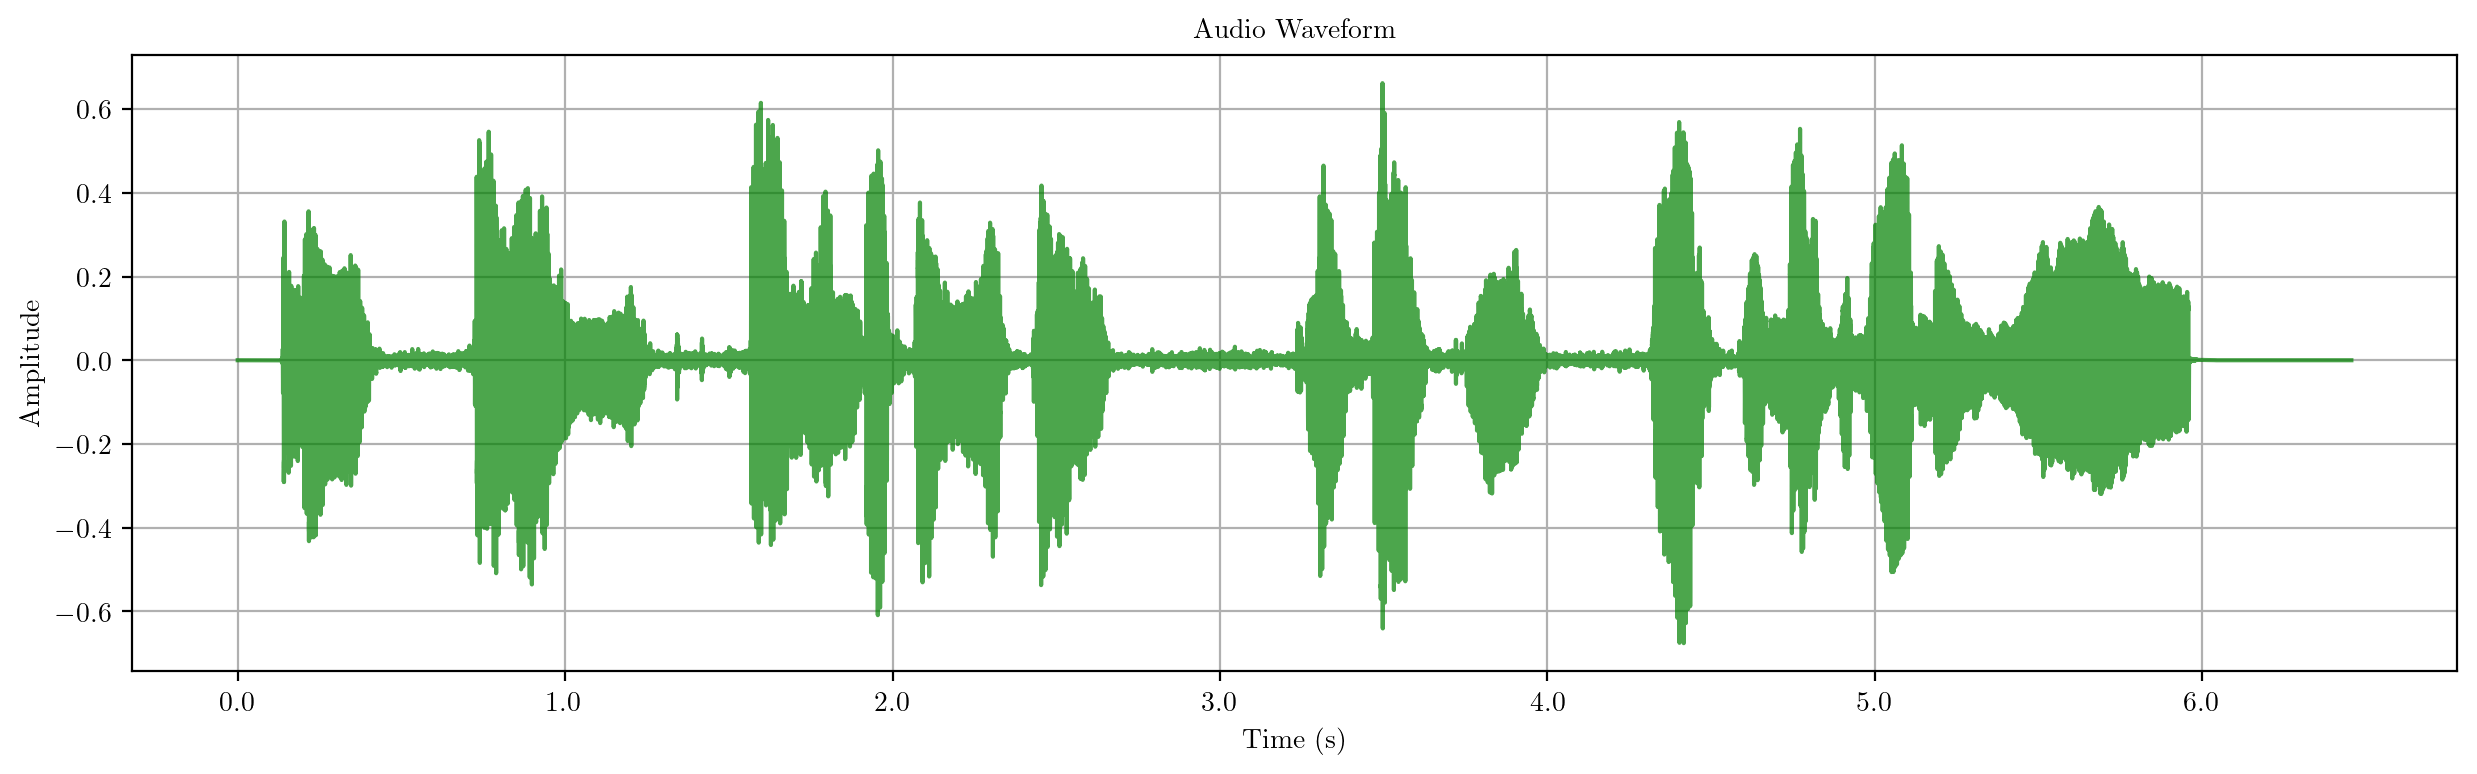

In [8]:
def audio_plot(audio, sr, clr, tl):
    plt.figure(figsize=(15, 4))
    plt.plot(audio, color = clr, alpha = 0.7)
    plt.xticks(np.arange(0, audio.shape[0], sr), np.arange(0, audio.shape[0] / sr, 1))
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title(tl)
    plt.grid()
    plt.show()
audio_plot(audio, sr, 'green', 'Audio Waveform')

**Clipping the audio to reduce time constraint problem**

torch.Size([144000])
tensor([-0.0176, -0.0210, -0.0254,  ...,  0.0000,  0.0000,  0.0000])


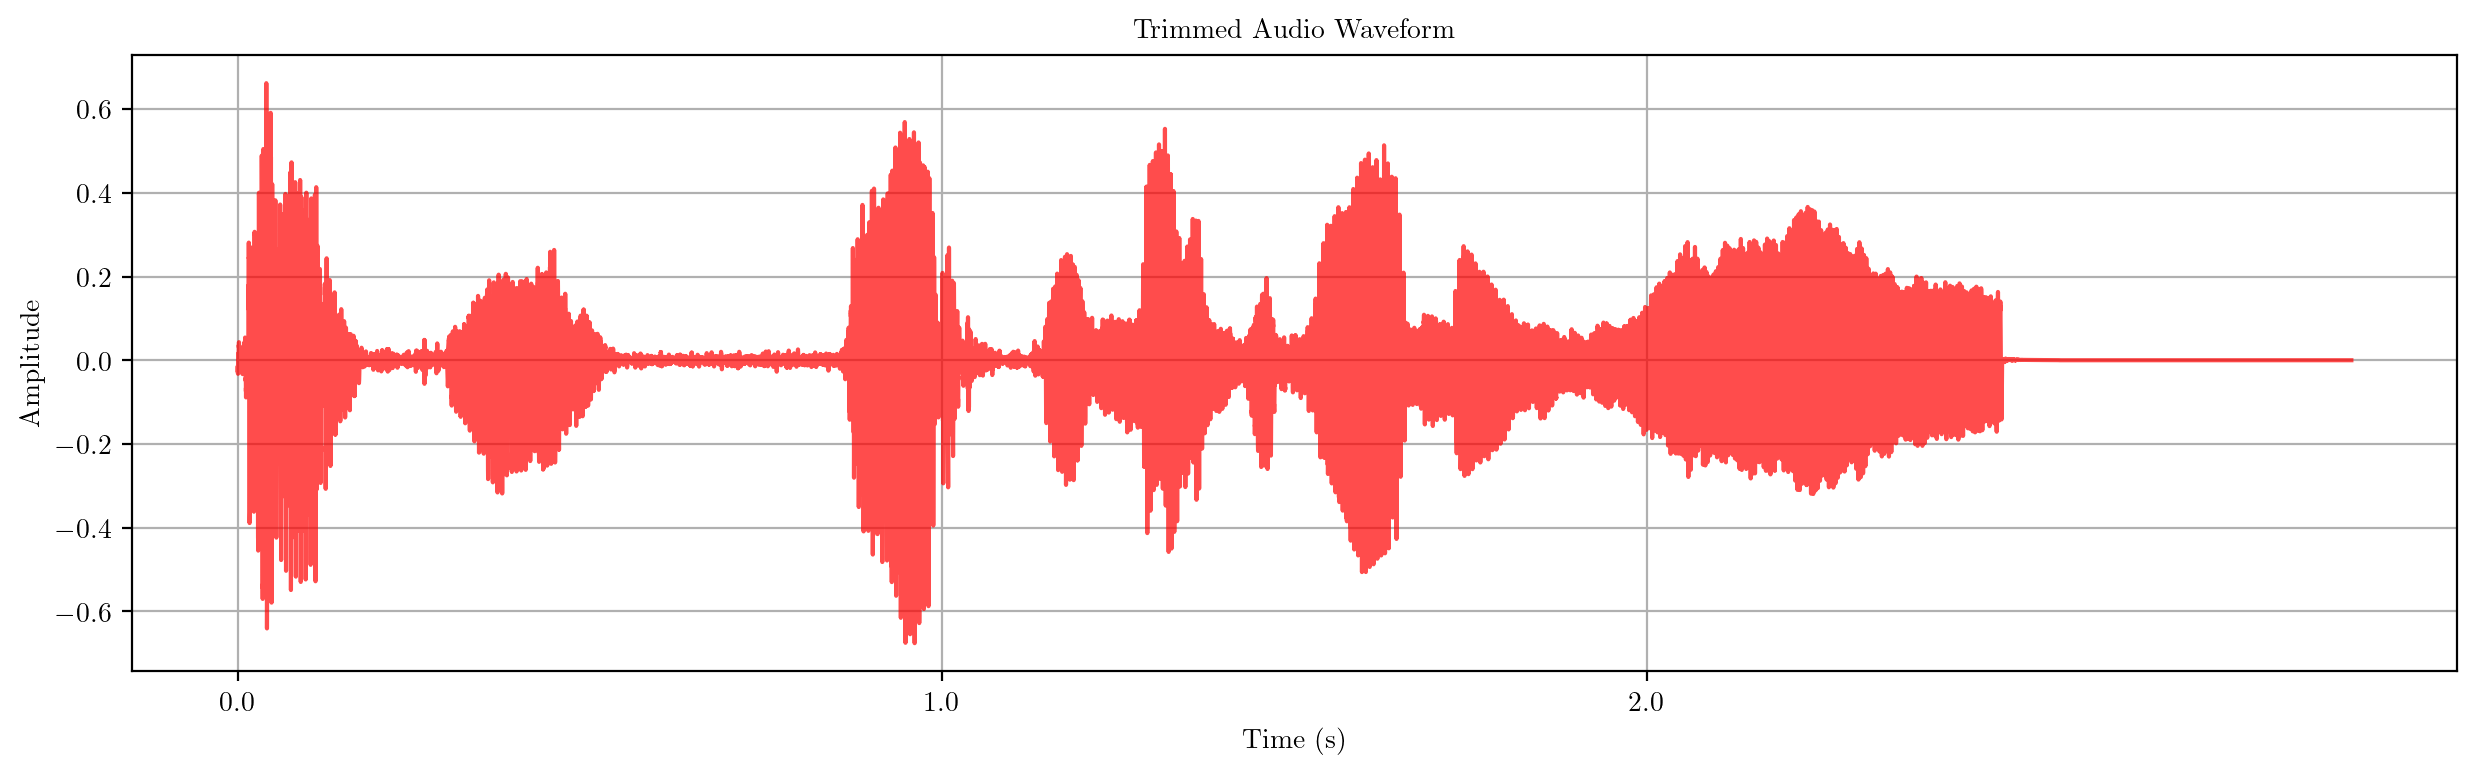

In [13]:
audio = audio[-4 * sr:]
print(audio.shape)
print(audio)
audio_plot(audio, sr, 'red', 'Trimmed Audio Waveform')

**Printing the audio tensor and Playing the trimmed audio**

In [16]:
X = torch.arange(0, len(audio)).unsqueeze(1).float()
X = X / X.max() * 200 - 100
print(X.shape)
print(X)

torch.Size([144000, 1])
tensor([[-100.0000],
        [ -99.9986],
        [ -99.9972],
        ...,
        [  99.9972],
        [  99.9986],
        [ 100.0000]])


In [17]:
Audio(audio, rate = sr)

**Using RFF Features and Gaussian Kernal**

In [18]:
from sklearn.kernel_approximation import RBFSampler

def create_rff_features(X, num_features, sigma):
    # Set a random state to the sampler for repoducibility
    rff = RBFSampler(n_components = num_features, gamma = 1 / (2 * sigma**2), random_state = 13)
    X = X.cpu().numpy()
    X = rff.fit_transform(X)
    return torch.tensor(X, dtype = torch.float32)
num_features = 5000
sigma = 0.008

X_rff = create_rff_features(X, num_features, sigma)
print(X_rff.shape)
print(X_rff)


torch.Size([144000, 5000])
tensor([[ 0.0088, -0.0179, -0.0190,  ..., -0.0196,  0.0071, -0.0053],
        [ 0.0065, -0.0189, -0.0190,  ..., -0.0197,  0.0084, -0.0076],
        [ 0.0042, -0.0196, -0.0189,  ..., -0.0198,  0.0097, -0.0098],
        ...,
        [-0.0117, -0.0197, -0.0146,  ...,  0.0054, -0.0024, -0.0111],
        [-0.0096, -0.0192, -0.0145,  ...,  0.0061, -0.0010, -0.0131],
        [-0.0074, -0.0183, -0.0144,  ...,  0.0068,  0.0005, -0.0148]])


**Fitting the model with the help of linear regression**

(144000,)
[-0.0686733  -0.06659724 -0.06435578 ... -0.15668242 -0.16112982
 -0.16526471]
tensor([-0.0176, -0.0210, -0.0254,  ...,  0.0000,  0.0000,  0.0000])


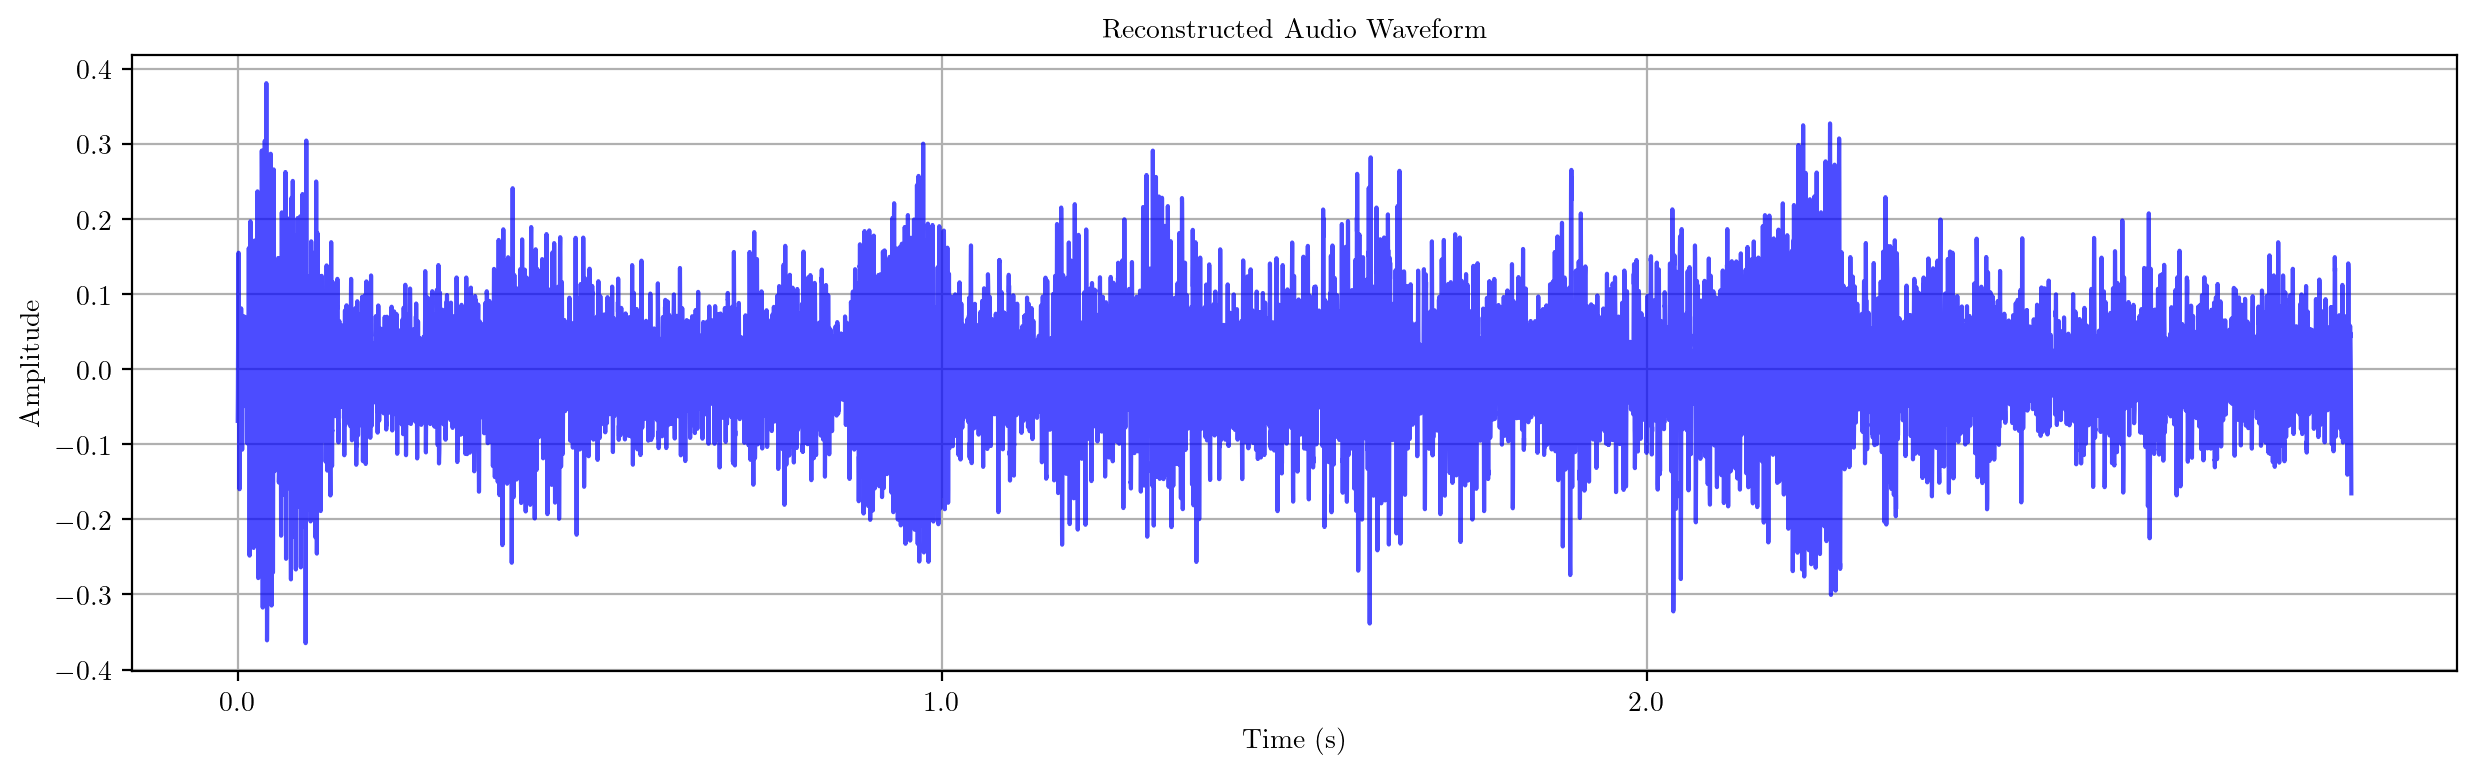

In [19]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_rff.numpy(), audio)

pred_audio = model.predict(X_rff.numpy())
print(pred_audio.shape)
import joblib
joblib.dump(model, 'model.pkl')
model = joblib.load('model.pkl')

import soundfile as sf
sf.write('pred_audio.wav', pred_audio, sr)
print(pred_audio)
print(audio)
np.linalg.norm(pred_audio - audio.numpy()), np.linalg.norm((pred_audio - audio.numpy()), ord = 1)
Audio(pred_audio, rate = sr)

audio_plot(pred_audio, sr, 'blue', 'Reconstructed Audio Waveform')

**Comparing the reconstructed audio with the original clipped one**

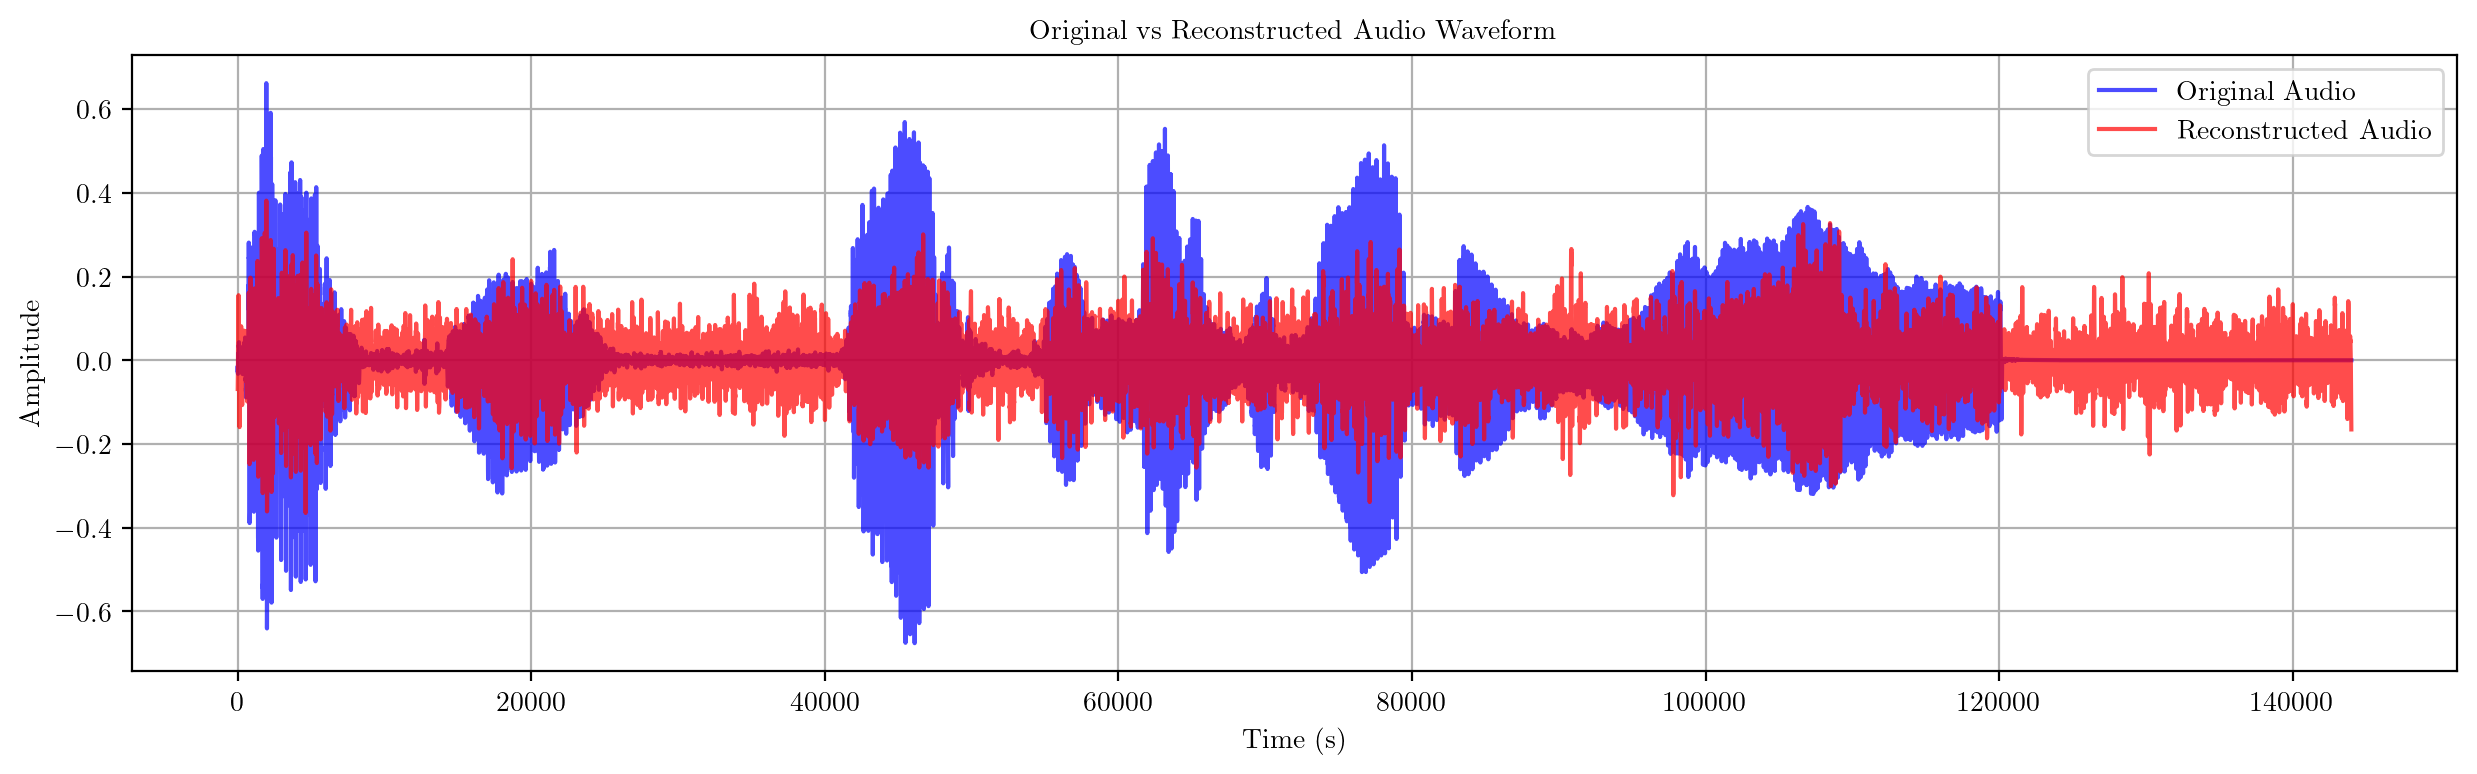

In [20]:
plt.figure(figsize=(15, 4))
plt.plot(audio, color = 'blue', alpha = 0.7, label = 'Original Audio')
plt.plot(pred_audio, color = 'red', alpha = 0.7, label = 'Reconstructed Audio')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Original vs Reconstructed Audio Waveform')
plt.grid()
plt.legend()
plt.show()

**Calculating RMSE AND SNR and playing the reconstructed audio**

In [21]:
Audio(pred_audio, rate = sr)

In [22]:
import numpy as np

# Function to calculate RMSE
def calculate_rmse(original, predicted):
    # Converting Torch Tensors to NumPy arrays for compatibility
    original = original.numpy()
    return np.sqrt(np.mean((original - predicted) ** 2))

# Function to calculate SNR
def calculate_snr(original, predicted):
    # Converting Torch Tensors to NumPy arrays for compatibility
    original = original.numpy()

    # Signal power
    signal_power = np.sum(original ** 2)
    # Noise power (difference between original and predicted)
    noise_power = np.sum((original - predicted) ** 2)
    # SNR calculation in decibels (dB)
    return 10 * np.log10(signal_power / noise_power)

# Ensure both audio signals have the same length (in case of mismatch)
pred_audio = pred_audio[:len(audio)]

# Calculate RMSE
rmse = calculate_rmse(audio, pred_audio)
print(f"RMSE: {rmse}")

# Calculate SNR
snr = calculate_snr(audio, pred_audio)
print(f"SNR: {snr} dB")



RMSE: 0.08487620204687119
SNR: 2.659309208393097 dB
